<a href="https://colab.research.google.com/github/Ahntea/pytorch_from_scratch/blob/main/conv_age_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.font_manager as fm
import os

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

# filename = "/content/drive/MyDrive/thumbnail_list.txt"
train_filename = "/content/drive/MyDrive/training_list.txt"
valid_filename = "/content/drive/MyDrive/valid_list.txt"

import unicodedata

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !(ls drive/MyDrive/training >> training_list.txt)
# !(ls drive/MyDrive/valid >> valid_list.txt)

In [3]:
# 한글 변환
train_list = []
with open(train_filename) as f:
    for line in f:
        train_list.append(unicodedata.normalize("NFC", line.strip()))

valid_list = []
with open(valid_filename) as f:
    for line in f:
        valid_list.append(unicodedata.normalize("NFC", line.strip()))

In [4]:
# train dataframe 생성
pd_train = pd.DataFrame(train_list)
pd_train["image"]= pd_train[0].str.replace('_PMT.jpg', '.jpg')
pd_train.rename(columns = {0:"filename"}, inplace = True)

# valid dataframe 생성
pd_valid = pd.DataFrame(valid_list)
pd_valid["image"]= pd_valid[0].str.replace('_PMT.jpg', '.jpg')
pd_valid.rename(columns = {0:"filename"}, inplace = True)

In [5]:
# image 생성날짜 dataframe 로드 및 merge
imt = pd.read_csv("/content/drive/MyDrive/csv_image_table_1015.csv")

merged = pd.merge(pd_train, imt, how="left", on = "image" )
merged['gen_date'] = pd.to_datetime(merged[['year','month','day']], format='%Y%m%d')
merged["birth_date"] = merged["image"].str.split('_', expand=True)[2]
merged["birth_date"] = merged["birth_date"].astype("datetime64[ns]")
merged["age"] = (merged["gen_date"] - merged["birth_date"]) / np.timedelta64(1, 'Y')
merged["age"].fillna(35, inplace=True)
merged["age"] = merged["age"].astype(int)
merged.loc[merged["age"]==119, "age"] = 19
merged["category"] = merged["image"].str.split('_', expand=True)[4]
d_ages = merged[['filename','age']].set_index('filename').T.to_dict('list')

In [6]:
merged.to_csv('train.csv',
                  sep=',',na_rep='NaN',columns = ['image','filename', 'age'],index = False)

In [7]:
# image 생성날짜 dataframe 로드 및 merge
imt = pd.read_csv("/content/drive/MyDrive/csv_image_table_1015.csv")

m_valid = pd.merge(pd_valid, imt, how="left", on = "image" )
m_valid['gen_date'] = pd.to_datetime(m_valid[['year','month','day']], format='%Y%m%d')
m_valid["birth_date"] = m_valid["image"].str.split('_', expand=True)[2]
m_valid["birth_date"] = m_valid["birth_date"].astype("datetime64[ns]")
m_valid["age"] = (m_valid["gen_date"] - m_valid["birth_date"]) / np.timedelta64(1, 'Y')
m_valid["age"].fillna(35, inplace=True)
m_valid["age"] = m_valid["age"].astype(int)
m_valid.loc[m_valid["age"]==119, "age"] = 19
m_valid["category"] = m_valid["image"].str.split('_', expand=True)[4]
valid_ages = m_valid[['filename','age']].set_index('filename').T.to_dict('list')
m_valid.to_csv('valid.csv',
                  sep=',',na_rep='NaN',columns = ['image','filename', 'age'],index = False)

In [8]:
m_valid.head(5)

,filename,image,Unnamed: 0,folder_num,year,month,day,hour,min,sec,gen_date,birth_date,age,category
0,곡효애_F_1979-12-25_6393_보톡스_399796_PMT.jpg,곡효애_F_1979-12-25_6393_보톡스_399796.jpg,0.0,6393.0,2018.0,10.0,15.0,13.0,23.0,0.0,2018-10-15,1979-12-25,38,보톡스
1,곡효애_F_1979-12-25_6393_보톡스_399797_PMT.jpg,곡효애_F_1979-12-25_6393_보톡스_399797.jpg,1.0,6393.0,2018.0,10.0,15.0,13.0,23.0,5.0,2018-10-15,1979-12-25,38,보톡스
2,곡효애_F_1979-12-25_6393_보톡스_399798_PMT.jpg,곡효애_F_1979-12-25_6393_보톡스_399798.jpg,2.0,6393.0,2018.0,10.0,15.0,13.0,23.0,10.0,2018-10-15,1979-12-25,38,보톡스
3,곡효애_F_1979-12-25_6393_보톡스_399799_PMT.jpg,곡효애_F_1979-12-25_6393_보톡스_399799.jpg,3.0,6393.0,2018.0,10.0,15.0,13.0,23.0,15.0,2018-10-15,1979-12-25,38,보톡스
4,고현진_F_1980-09-27_23730_윤곽주사_456266_PMT.jpg,고현진_F_1980-09-27_23730_윤곽주사_456266.jpg,2.0,23730.0,2019.0,3.0,2.0,14.0,5.0,27.0,2019-03-02,1980-09-27,38,윤곽주사


In [9]:
import torch
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class CustomDataset(torch.utils.data.Dataset): 
  def __init__(self, csv_file, root_dir, transform=None):
    self.csv_file = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    load_data = self.csv_file
    return len(load_data)
  
  def __getitem__(self, idx): 
    img_name = os.path.join(self.root_dir, self.csv_file.iloc[idx, 1])
    image = io.imread(img_name)
    label = self.csv_file.iloc[idx,2]

    # sample = {'image' : image, 'label' : label}
    sample = {'image' : image, 'label' : np.array(label)}
    if self.transform:
      sample = self.transform(sample)
    return sample
      

In [10]:
train_ds = CustomDataset('train.csv', '/content/drive/MyDrive/training/')
valid_ds = CustomDataset('valid.csv', '/content/drive/MyDrive/valid/')

In [11]:
print(train_ds[3]['image'].shape, valid_ds[3]['image'].shape)

(96, 100, 3) (96, 100, 3)


In [12]:
# for image, age in dataset:
#   print(image.shape)

In [13]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        # image, age =sample
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively

        return {'image' : img, 'label' : label}

In [14]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        label = sample['label']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        img = image.transpose((2, 0, 1))
        # return {'image' : torch.from_numpy(img), 'label' :torch.from_numpy(label)}
        return torch.from_numpy(img).float(), torch.from_numpy(label).float()

In [15]:
scale = Rescale((96,100))
composed = transforms.Compose([Rescale((96,100))])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = train_ds[65]
for i, tsfrm in enumerate([scale,composed]):
    transformed_sample = tsfrm(sample)
    print(transformed_sample['image'].shape)

(96, 100, 3)
(96, 100, 3)


<Figure size 432x288 with 0 Axes>

In [16]:
# transformed_dataset = CustomDataset(csv_file='agedata.csv',root_dir='/content/drive/MyDrive/training/',
#                                     transform=transforms.Compose([Rescale((96,100)),ToTensor()]))
train_dataset = CustomDataset(csv_file='train.csv',root_dir='/content/drive/MyDrive/training/',  transform=transforms.Compose([
                                               Rescale((96,100)),
                                               ToTensor()
                                           ]))
valid_dataset = CustomDataset(csv_file='valid.csv',root_dir='/content/drive/MyDrive/valid/',  transform=transforms.Compose([
                                               Rescale((96,100)),
                                               ToTensor()
                                           ]))

In [17]:
print(train_dataset)
# print(transformed_dataset[0]['label'])

In [18]:
train_dl = DataLoader(train_dataset, batch_size=8,shuffle=True, num_workers=0)
valid_dl = DataLoader(valid_dataset, batch_size=16,shuffle=True, num_workers=0)

In [19]:
i= 0

for x, y in train_dl:
  if i==3:
    break
  # print(x.shape,y.reshape(len(y),1).shape)
  # print(torch.flatten(x, start_dim=1).shape, y)
  print(x.shape, y.reshape(len(y),1).shape)
  i += 1

torch.Size([8, 3, 96, 100]) torch.Size([8, 1])
torch.Size([8, 3, 96, 100]) torch.Size([8, 1])
torch.Size([8, 3, 96, 100]) torch.Size([8, 1])


In [38]:
import torch
from torch import nn
from torch import optim
class Age_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(28800, 7200)
        self.lin2 = nn.Linear(7200, 100)
        self.lin3 = nn.Linear(100, 1)

    def forward(self, xb):
        xb = torch.flatten(xb, start_dim=1)
        xb = self.lin1(xb)
        xb = self.lin2(xb)
        return self.lin3(xb)

In [39]:
def get_model():
    model = Age_Regression()
    return model, optim.SGD(model.parameters(), lr=1e-5)

In [40]:
model, opt = get_model()

In [41]:
loss_func = nn.MSELoss()

In [42]:
epochs = 50

In [44]:
losses = []
for epoch in range(epochs):
  model.train()
  for train_x,train_y in train_dl:
    # pred = model(train_x.float())
    pred = model(train_x)
    # loss = loss_func(pred, train_y.reshape(len(train_y),1).float())
    loss = loss_func(pred, train_y.reshape(len(train_y),1))

    loss.backward()
    opt.step()
    opt.zero_grad()

  model.eval()
  with torch.no_grad():
    # valid_loss = sum(loss_func(model(xb.float()), yb.reshape(len(yb),1)) for xb, yb in valid_dl)
    valid_loss = sum(loss_func(model(xb), yb.reshape(len(yb),1)) for xb, yb in valid_dl)

  # lossed = loss_func(model(train_x.float()),train_y.reshape(len(train_y),1))
  lossed = loss_func(model(train_x),train_y.reshape(len(train_y),1))
  losses.append(lossed)
  print(epoch, lossed, valid_loss/len(valid_dl))

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(),"fc_model.pth")

In [ ]:
sc = []
for lo in losses:
  sc.append(lo.item())

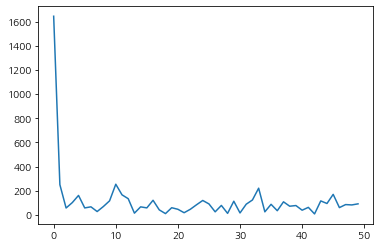

In [ ]:
plt.plot(sc)

In [20]:
import torch
from torch import nn
from torch import optim
class Conv_Regression(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = torch.nn.Sequential(
        nn.Linear(38400, 7200),
        nn.Linear(7200, 100),
        nn.Linear(100, 1))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.layer3(out)
        return out

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
def get_cmodel():

    model = Conv_Regression().to(device)
    return model, optim.Adam(model.parameters(), lr=1e-6)

Using cuda device


In [22]:
cmodel, opt = get_cmodel()
loss_func = nn.MSELoss().to(device)
epochs = 100

In [23]:
losses = []
for epoch in range(epochs):
  cmodel.train()
  for train_x,train_y in train_dl:
    pred = cmodel(train_x.to(device))
    loss = loss_func(pred, train_y.reshape(len(train_y),1).to(device))

    loss.backward()
    opt.step()
    opt.zero_grad()

  cmodel.eval()
  with torch.no_grad():
    valid_loss = sum(loss_func(cmodel(xb.to(device)), yb.reshape(len(yb),1).to(device)) for xb, yb in valid_dl)

  lossed = loss_func(cmodel(train_x.to(device)), train_y.reshape(len(train_y),1).to(device))
  losses.append(lossed)
  print(epoch, lossed, valid_loss/len(valid_dl))

0 tensor(1590.4934, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(852.5737, device='cuda:0')
1 tensor(868.3387, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(842.8268, device='cuda:0')
2 tensor(1234.1830, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(798.5914, device='cuda:0')
3 tensor(1003.8865, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(678.2126, device='cuda:0')
4 tensor(1036.8175, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(776.6501, device='cuda:0')
5 tensor(1290.2875, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(589.2900, device='cuda:0')
6 tensor(1532.8978, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(620.3739, device='cuda:0')
7 tensor(880.1970, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(617.1332, device='cuda:0')
8 tensor(1018.9535, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(495.2633, device='cuda:0')
9 tensor(845.0836, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(494.1688, device='cuda:0')
10 tensor(710

In [24]:
sc = []
for lo in losses:
  sc.append(lo.item())

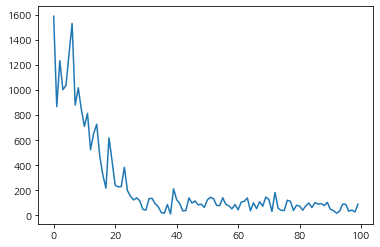

In [25]:
plt.plot(sc)

In [32]:
conv1 = nn.Conv2d(3,32,3, padding=1)
conv2 = nn.Conv2d(32,64,3, padding=1)
pool = nn.MaxPool2d(2)
i=0
for x, y in train_dl:
  if i==2:
    break
  # print(x.shape,y.reshape(len(y),1).shape)
  # print(torch.flatten(x, start_dim=1).shape, y)
  print(conv1(x.float()).shape, y.reshape(len(y),1).shape)
  print(pool(conv2(pool(conv1(x.float())))).shape, y.reshape(len(y),1).shape)

  i += 1

torch.Size([8, 32, 96, 100]) torch.Size([8, 1])
torch.Size([8, 64, 24, 25]) torch.Size([8, 1])
torch.Size([8, 32, 96, 100]) torch.Size([8, 1])
torch.Size([8, 64, 24, 25]) torch.Size([8, 1])


In [33]:
print(64*24*25)

38400


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=9600, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [ ]:
X = torch.rand(3, 96, 100, device=device)
logits = model(X)
pred_probab = nn.MSELoss()
y_pred = logits
print(f"Predicted class: {y_pred}")

Predicted class: tensor([[0.0515],
        [0.0711],
        [0.0528]], grad_fn=<AddmmBackward0>)
